In [1]:
%load_ext autoreload
%autoreload 2

from loguru import logger
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm


In [49]:
import torch


class ActivationShapingS(torch.nn.Module):

    def __init__(self, pruning_level: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pruning_level = pruning_level

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, hidden_size = inputs.shape
        fattened = inputs.reshape((batch_size, -1))
        sum_1 = torch.sum(fattened, dim=1)

        percentile = torch.quantile(fattened, self.pruning_level, dim=-1).unsqueeze(-1).unsqueeze(-1).expand(-1, seq_len, hidden_size)
        x_with_zeros = torch.where(inputs > percentile, inputs, torch.zeros_like(inputs))
        sum_2 = torch.sum(x_with_zeros.reshape((batch_size, -1)), dim=1)

        # Avoid division by zero
        exp_ratio = torch.exp(sum_1 / (sum_2 + 1e-6)).unsqueeze(-1).unsqueeze(-1).expand(-1, seq_len, hidden_size)
        
        return x_with_zeros * exp_ratio
    
    
activation_shaping = ActivationShapingS(pruning_level=0.10)

data = torch.randn(256, 1, 64)

activation_shaping(data)

tensor([[[-0.1480, -1.6247, -0.8529,  ..., -0.0235, -1.9434,  2.3578]],

        [[-0.0154, -0.0133, -0.0148,  ..., -0.0272, -0.0379,  0.0578]],

        [[ 0.0580,  0.0000,  0.0098,  ...,  0.2967,  0.0504,  0.0887]],

        ...,

        [[ 0.0000,  0.0000,  0.0437,  ..., -0.0757, -0.0031, -0.0793]],

        [[ 0.1870,  0.1267,  0.0000,  ...,  0.2740,  0.4231,  0.3297]],

        [[ 0.0000,  0.2041,  0.0270,  ...,  0.0036,  0.0000,  0.2036]]])

In [6]:

from adn.data import DatasetMode, load_datasets

individuals_snp_dir = Path("data/output/SNPs/")
metadata_path = Path("data/DIVRICE_3k10M_ch1/DIVRICE_3k10M_metadata.tsv")
sequence_length = 128
train_eval_split = 0
labels_to_remove = "cA"
individuals_to_ignore = Path("data/bad_guys.txt")

ds, _ = load_datasets(
    individuals_snp_dir=Path(individuals_snp_dir),
    metadata_path=Path(metadata_path),
    sequence_length=sequence_length,
    train_eval_split=train_eval_split,
    data_ratio_to_use=1,
    mode=DatasetMode.SEQUENTIAL_FIXED_LEN,
    labels_to_remove=labels_to_remove,
    individual_to_ignore=individuals_to_ignore,
    overlaping_ratio=0.5,
)

Output()

2025-03-22 15:26:19.777 | INFO     | adn.data:load_metadata:43 - Using labels: {'XI', 'GJ'}. Excluding: {'cA'}
2025-03-22 15:26:19.790 | INFO     | adn.data:load_metadata:52 - Ignoring individuals: {'CX49,', 'IRIS_313-10998', 'IRIS_313-10054', 'B047', 'IRIS_313-11286', 'IRIS_313-10771', 'B155', 'CX367', 'IRIS_313-11808', 'B037', 'CX11,', 'CX12,', 'IRIS_313-11656', 'IRIS_313-9348', 'IRIS_313-10300', 'IRIS_313-10318', 'IRIS_313-10268', 'IRIS_313-7725', 'IRIS_313-9841', 'IRIS_313-11380', 'IRIS_313-10158', 'B176', 'CX282', 'IRIS_313-11807', 'IRIS_313-9400', 'IRIS_313-9066,', 'IRIS_313-9817', 'CX284', 'IRIS_313-11153', 'IRIS_313-9600', 'CX243', 'B051'}


/home/pierre/dev/DNA/adn/data.py:29: TqdmExperimentalWarning: rich is experimental/alpha
  iterrable = tqdm(snp_parquet_files, desc="Loading SNP data...")


2025-03-22 15:26:22.610 | INFO     | adn.data:load_datasets:103 - Train test split set to 0, using all data for training
2025-03-22 15:26:22.613 | INFO     | adn.data:load_datasets:142 - Train dataset loaded with 2617 individuals


In [7]:
from adn.prediction_results import OnDiskPredictionResults


res = OnDiskPredictionResults(Path("output/v7-seq-len-128/predictions/"), workers=8)
errors_df = res.compute_error()

Computing errors: 100%|██████████| 2616/2616 [00:09<00:00, 264.45file/s]


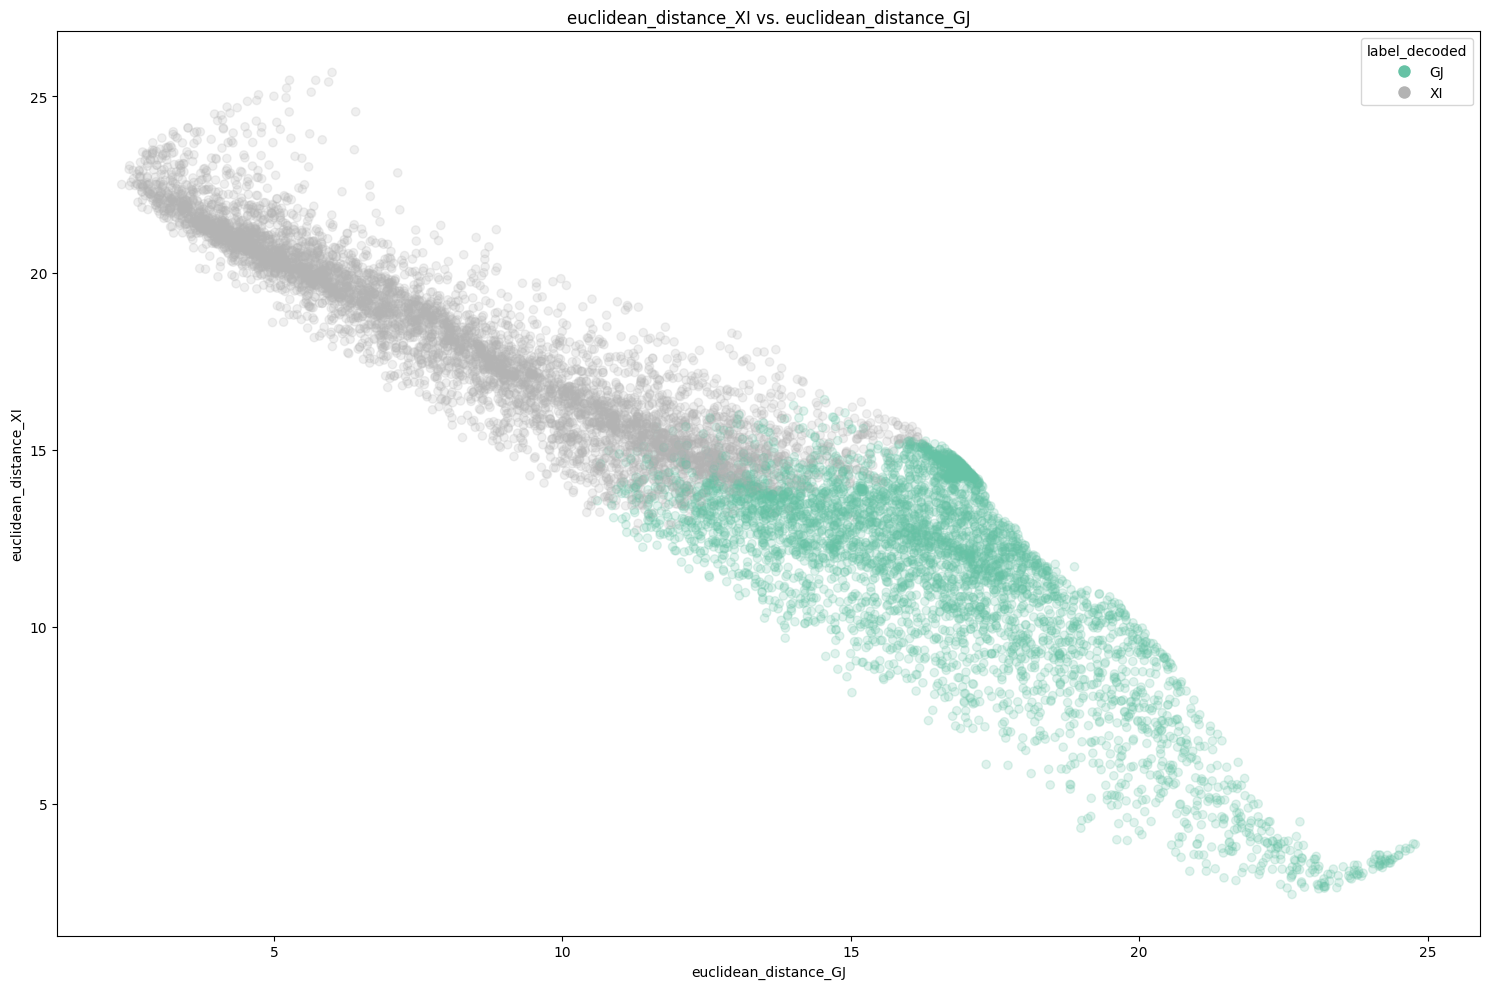

In [8]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import Colormap

def plot_euclidean_scatter(
    df: pd.DataFrame,
    sample_size: int = 10000,
    alpha: float = 0.2,
    cmap: Colormap = plt.cm.Set2
) -> None:
    sample = df.sample(min(sample_size, len(df)))

    label_col = "label_decoded"
    x_col = "euclidean_distance_GJ"
    y_col = "euclidean_distance_XI"
    
    label_categorical = pd.Categorical(sample[label_col])
    categories = label_categorical.categories
    codes = label_categorical.codes

    num_categories = len(categories)

    fig, ax = plt.subplots(figsize=(15, 10))

    ax.scatter(
        sample[x_col],
        sample[y_col],
        alpha=alpha,
        c=codes,
        cmap=cmap,
    )

    ax.set_title(f"{y_col} vs. {x_col}")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    handles = [
        plt.Line2D(
            [], [], 
            marker="o", 
            color="w", 
            markerfacecolor=cmap(i / (num_categories - 1)),
            markersize=10, 
            label=cat
        )
        for i, cat in enumerate(categories)
    ]

    ax.legend(
        loc="best",
        handles=handles,
        title=label_col,
    )

    plt.tight_layout()
    plt.show()

plot_euclidean_scatter(
    errors_df,
    sample_size=10000,
)

In [20]:

def filter_errors(errors_df: pd.DataFrame, label_centroid_min_dist: float, other_centroid_max_dist: float) -> pd.DataFrame:
    
    def should_keep_row(row: pd.Series) -> bool:
        label = row["label_decoded"]
        label_centroid_distance_col_name = f"euclidean_distance_{label}"
        label_centroid_distance = row[label_centroid_distance_col_name]
        other_centroid_distance_cols = list(filter(lambda x: x.startswith("euclidean_distance_") and x != label_centroid_distance_col_name, row.index))
        return label_centroid_distance > label_centroid_min_dist and any(row[other_centroid_distance_cols] < other_centroid_max_dist)
    
    filtered_df = errors_df[errors_df.apply(should_keep_row, axis=1)]
    return filtered_df

filtered_errors_df = errors_df #filter_errors(errors_df, label_centroid_min_dist=15, other_centroid_max_dist=10)

In [21]:
unique_labels = filtered_errors_df["label_decoded"].unique()
label_to_array = {label: np.zeros(ds.max_position) for label in unique_labels}

def min_max_scaler(s: pd.Series) -> pd.Series:
    min_val = s.min()
    max_val = s.max()
    if min_val == max_val:
        return s
    return (s - min_val) / (max_val - min_val)

for col in filtered_errors_df.columns:
    if col.startswith("euclidean_distance_"):
        filtered_errors_df[f"{col}_scaled"] = min_max_scaler(filtered_errors_df[col])
        

for i, row in tqdm(filtered_errors_df.iterrows(), total=len(filtered_errors_df)):
    label = row["label_decoded"]
    start_position = row["start_position"]
    end_position = row["end_position"]
    
    if label == "XI":
        scaled_distance = row["euclidean_distance_GJ_scaled"]
    else:
        scaled_distance = row[f"euclidean_distance_XI_scaled"]
    
    inv_scaled_distance = 1 - scaled_distance
    
    label_to_array[label][start_position:end_position] += inv_scaled_distance
    
    

100%|██████████| 36140/36140 [00:03<00:00, 9396.58it/s] 


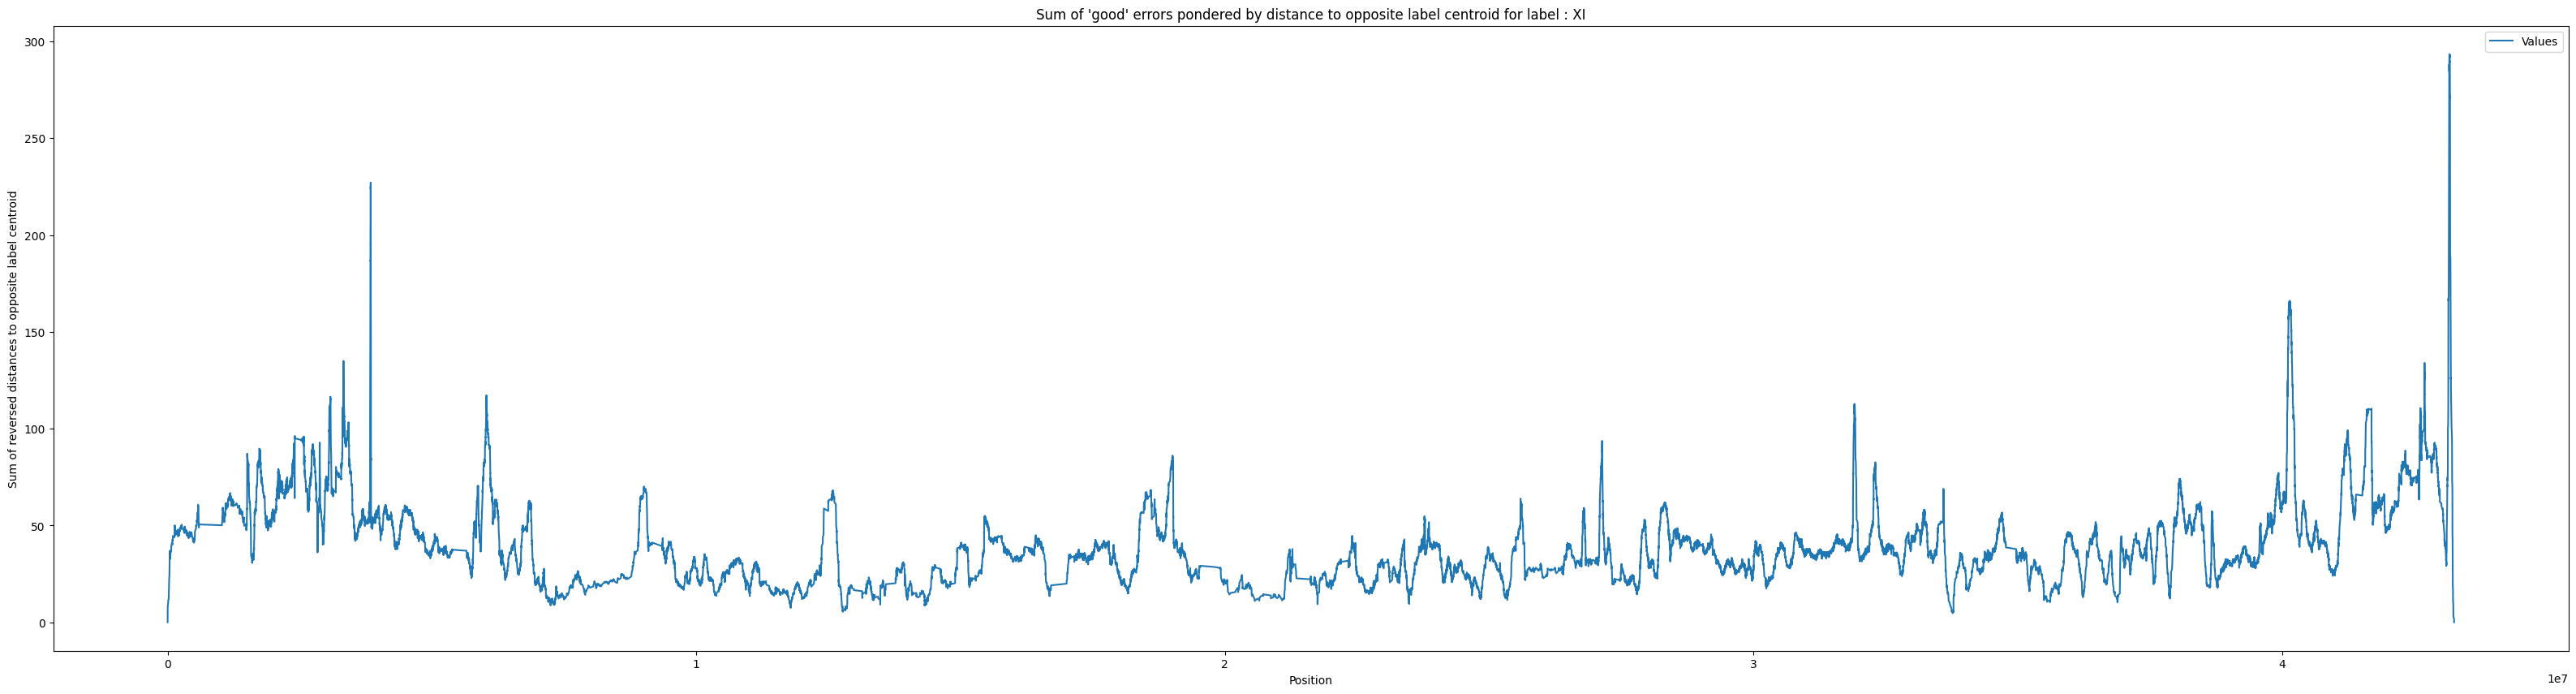

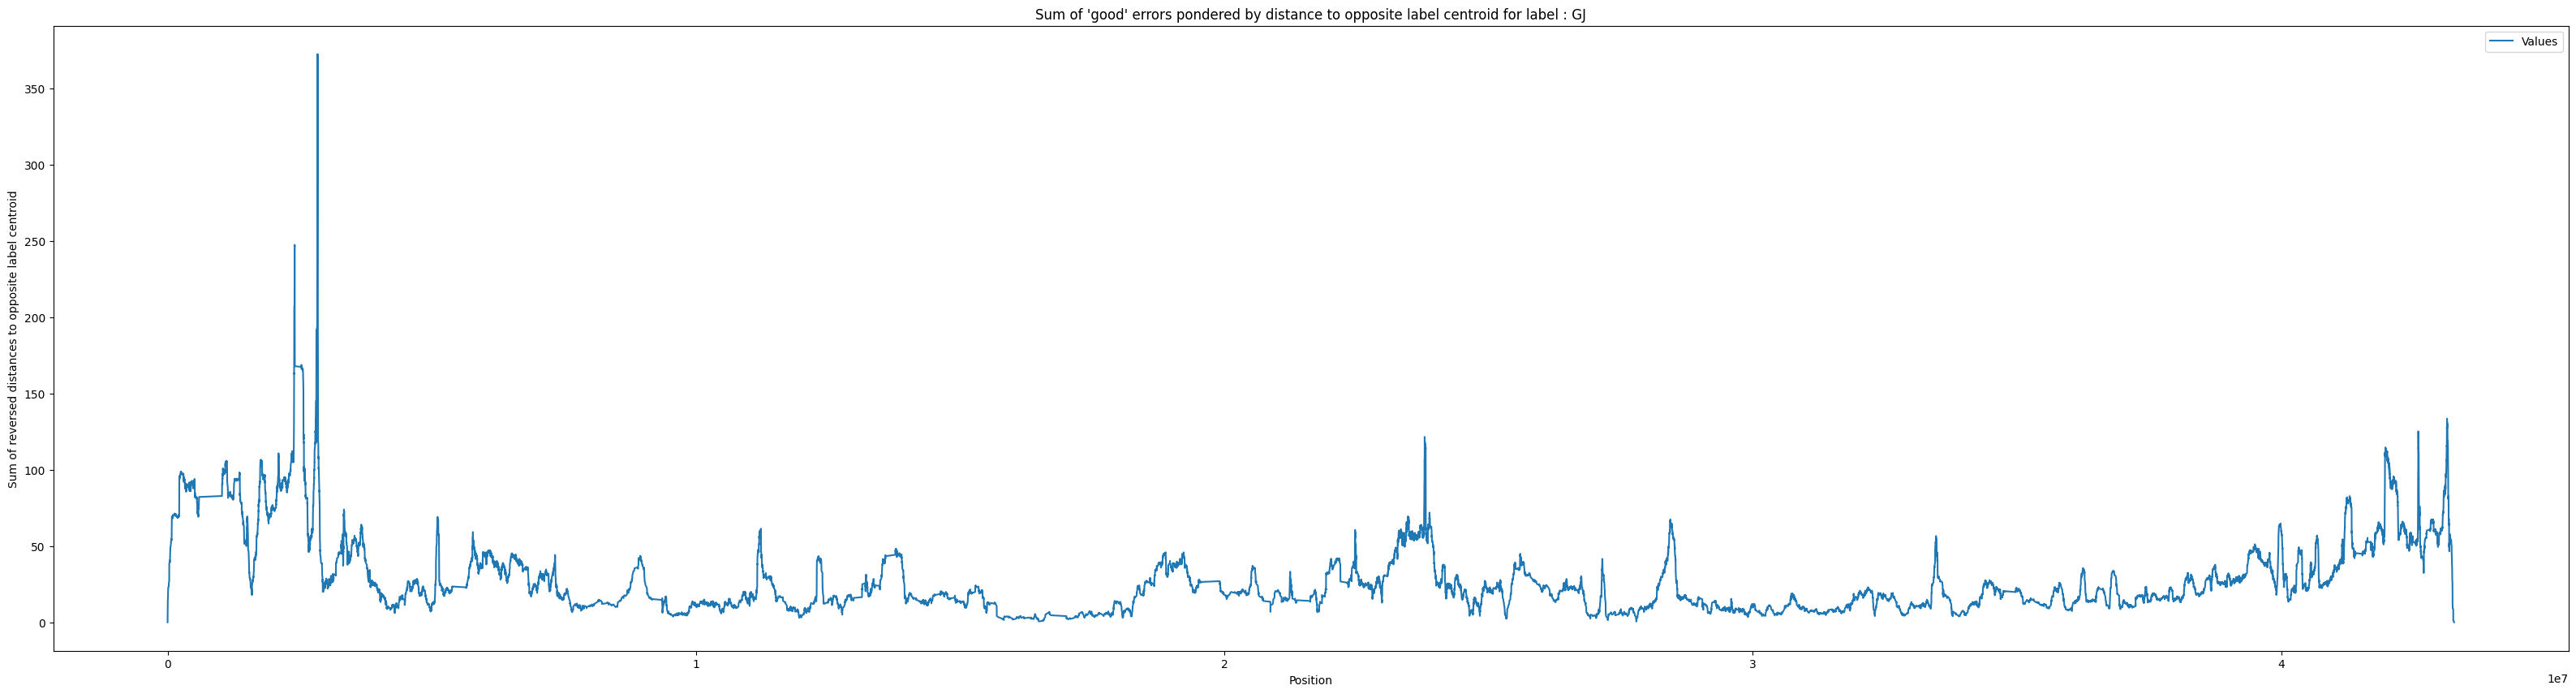

In [23]:


for label, array in label_to_array.items():
    values_df = pd.DataFrame({"values": array})
    values_df = values_df.mask(values_df == values_df.shift()).dropna()
    
    title = f"Sum of 'good' errors pondered by distance to opposite label centroid for label : {label}"
    
    ax = values_df.plot.line(y="values", title=title, figsize=(40, 10), legend=True)
    
    ax.legend(["Values"])
    ax.set_xlabel("Position")
    ax.set_ylabel("Sum of reversed distances to opposite label centroid")